In [1]:
import pandas as pd
import numpy as np

In [2]:
df_raw_All = pd.read_csv('OrganicElectrodesAll.csv')

In [3]:
df_All = df_raw_All.drop_duplicates(subset='SMILES', keep='first')

In [4]:
df_All.shape

(2415, 2)

- To sanitize SMILES strings in an RDKit-compatible format, use RDKit to process each SMILES string and filter out those that fail the sanitization process.

In [5]:
from rdkit import Chem
from rdkit.Chem import MolToSmiles

# Function to sanitize SMILES strings
def sanitize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=True)
        if mol is not None:
            # Return canonical SMILES if sanitization is successful
            return MolToSmiles(mol, canonical=True)
        else:
            return None
    except:
        return None


In [6]:
# Apply sanitization to the DataFrame
df_All['smiles'] = df_All['SMILES'].apply(sanitize_smiles)

# Filter out rows with invalid SMILES
df_All = df_All.dropna(subset=['smiles'])

C:\Users\xueli\AppData\Local\Temp\ipykernel_18872\1608062887.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_All['smiles'] = df_All['SMILES'].apply(sanitize_smiles)


In [7]:
df_All.shape

(2415, 3)

In [8]:
df_All.head()

,Voltage,SMILES,smiles
0,2.95,O=C1C2=C(O)C=CC(O)=C2C(=O)C2=C1C(=O)C1=C(C2=O)...,O=c1c2c(O)ccc(O)c2c(=O)c2c(=O)c3c(=O)c4c(=O)c5...
1,2.40,O=C(C1=C(C(S(=O)(O[Na])=O)=CC=C1)C2=O)C3=C2C=C...,O=C1c2cccc(S(=O)(=O)O[Na])c2C(=O)c2cccc(S(=O)(...
2,2.40,OC(C1=C2C=CC=C1S(=O)(O)=O)=C3C(C(S(=O)(O)=O)=C...,O=S(=O)(O)c1cccc2c(O)c3c(S(=O)(=O)O)cccc3c(O)c12
3,2.25,O=C1C2=C(C=CC=C2)C(=O)C2=C1C=CC=C2S(=O)(=O)O[Na],O=C1c2ccccc2C(=O)c2c1cccc2S(=O)(=O)O[Na]
4,2.25,OC(C1=C2C=CC=C1S(=O)(O)=O)=C3C(C=CC=C3)=C2O,O=S(=O)(O)c1cccc2c(O)c3ccccc3c(O)c12


### Data Augmentation Only on Training Dataset

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

# Step 1: Split data using StratifiedShuffleSplit
# Example binning of voltage values
bins = [0, 1.9, 2.7, 3.5, 5]  # Adjust based on your data range
labels = ['very low', 'low', 'medium', 'high']
df_All['Voltage_Binned'] = pd.cut(df_All['Voltage'], bins=bins, labels=labels)

# Perform stratified split using the binned voltage column
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in splitter.split(df_All, df_All['Voltage_Binned']):
    train_df = df_All.iloc[train_index]
    test_df = df_All.iloc[test_index]


In [10]:
train_df.to_csv('train_df_Agmt_Rdkit.csv', index=False)
test_df.to_csv('test_df_Agmt_Rdkit.csv', index=False)

In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

# Function to generate different SMILES representations
def generate_smiles_variants(smiles, num_variants=5):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []  # Return an empty list if the SMILES string is invalid

    # Add explicit hydrogens
    mol = Chem.AddHs(mol)

    # Generate conformers
    AllChem.EmbedMolecule(mol, randomSeed=42)  # Ensure reproducibility

    # Generate different canonical SMILES by modifying the molecule
    smiles_variants = set()
    for _ in range(num_variants):
        # Generate a new conformer
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)  # Add hydrogens to the new molecule
        AllChem.EmbedMolecule(mol, randomSeed=42)  # Generate new conformer
        
        # Generate non-canonical SMILES
        new_smiles = Chem.MolToSmiles(mol, canonical=False)
        smiles_variants.add(new_smiles)
    
    return list(smiles_variants)

# Initialize a list to store rows for the augmented dataframe
rows = []

# Iterate over each row and generate variants
for index, row in train_df.iterrows():
    smiles = row['SMILES']
    voltage = row['Voltage']
    variants = generate_smiles_variants(smiles)
    for variant in variants:
        rows.append({'SMILES': variant, 'Voltage': voltage})

# Convert list of rows to DataFrame
augmented_df = pd.DataFrame(rows)

# Save augmented dataframe
augmented_df.to_csv('augmented_df_All_Rdkit.csv', index=False)


[11:36:11] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[11:36:11] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[11:36:11] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[11:36:11] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[11:36:11] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[11:36:11] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[11:36:30] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[11:36:30] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[11:36:30] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[11:36:30] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[11:36:30] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[11:36:30] UFFTYPER: Warning: hybridization set to SP3 for atom 4


In [40]:
# Import saved files
train_df = pd.read_csv('train_df_Agmt_Rdkit.csv')
test_df = pd.read_csv('test_df_Agmt_Rdkit.csv')
augmented_df = pd.read_csv('augmented_df_All_Rdkit.csv')

In [12]:
augmented_df.shape

(1690, 2)

In [13]:
augmented_df.head()

,SMILES,Voltage
0,Clc1c([H])c([H])c(Cl)c2c1C(=O)C([H])=C([H])C2=O,2.663037
1,O=c1c(Cl)c([H])c(=O)c2c(=O)c(Cl)c(Cl)c(=O)c1=2,3.655935
2,[Li]OC(C1=C(C(O[Li])(O[Li])[H])SC(=C2SC(C(O[Li...,1.200000
3,Fc1c([H])c(S[Li])c(F)c([H])c1S[Li],2.400000
4,C(Oc1c(OC([H])([H])[H])c([H])c([H])c2c([H])c(O...,2.670670


In [14]:
train_df.head()

,Voltage,SMILES,smiles,Voltage_Binned
2162,2.663037,Clc1ccc(Cl)c(c12)C(=O)C=CC2=O,O=C1C=CC(=O)c2c(Cl)ccc(Cl)c21,low
2016,3.655935,O=c1c(Cl)cc(=O)c(c12)c(=O)c(Cl)c(Cl)c2=O,O=c1cc(Cl)c(=O)c2c(=O)c(Cl)c(Cl)c(=O)c1=2,high
889,1.200000,[Li]OC(C1=C(S/C(S1)=C2SC(C(O[Li])O[Li])=C(S/2)...,[Li]OC(O[Li])C1=C(C(O[Li])O[Li])SC(=C2SC(C(O[L...,very low
908,2.400000,FC(C=C1S[Li])=C(C=C1F)S[Li],[Li]Sc1cc(F)c(S[Li])cc1F,low
1675,2.670670,COc1c(OC)ccc2cc(OC)c(c3c12)/C(=N/S(=O)(=O)C)/C...,COC1=C(OC)c2c(c(OC)cc3ccc(OC)c(OC)c23)C(=N/S(C...,low


In [15]:
train_df.shape

(1690, 4)

In [14]:
test_df.shape

(725, 4)

In [15]:
# Delete 'Voltage_Binned' column from both train_df and test_df
train_df = train_df.drop(columns=['Voltage_Binned'])
test_df = test_df.drop(columns=['Voltage_Binned'])

In [16]:

# Step 3: Merge augmented data with original train data and test data
augmented_df['Augmented'] = 1
train_df['Augmented'] = 1
test_df['Augmented'] = 0
df_All_augmented = pd.concat([augmented_df,train_df, test_df], ignore_index=True)


In [17]:
df_All_augmented.head()

,SMILES,Voltage,Augmented,smiles
0,Clc1c([H])c([H])c(Cl)c2c1C(=O)C([H])=C([H])C2=O,2.663037,1,NaN
1,O=c1c(Cl)c([H])c(=O)c2c(=O)c(Cl)c(Cl)c(=O)c1=2,3.655935,1,NaN
2,[Li]OC(C1=C(C(O[Li])(O[Li])[H])SC(=C2SC(C(O[Li...,1.200000,1,NaN
3,Fc1c([H])c(S[Li])c(F)c([H])c1S[Li],2.400000,1,NaN
4,C(Oc1c(OC([H])([H])[H])c([H])c([H])c2c([H])c(O...,2.670670,1,NaN


In [18]:
df_All_augmented.shape

(4105, 4)

In [19]:
df_All_augmented = df_All_augmented.drop_duplicates(subset='SMILES', keep='first')

In [20]:
df_All_augmented.shape

(4090, 4)

In [21]:
df_All = df_All_augmented.copy()

In [22]:
df_All.shape

(4090, 4)

# Exploratory Data Analysis (EDA)

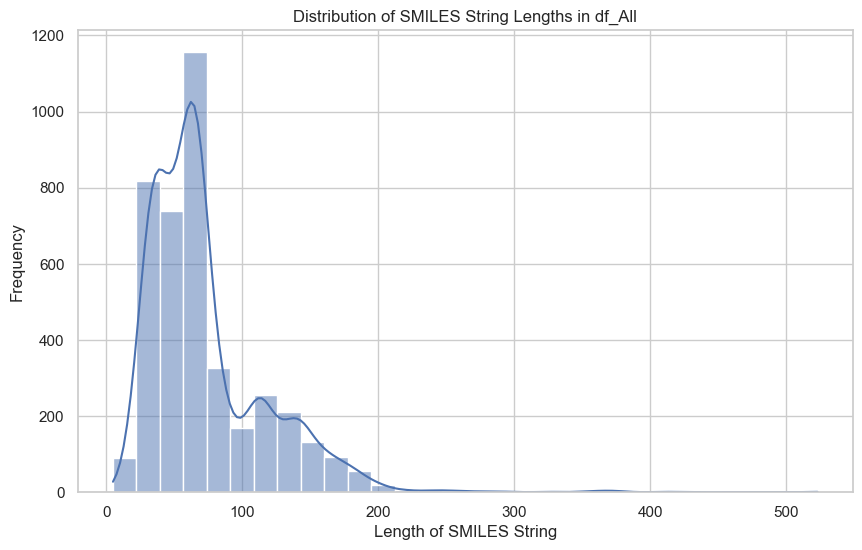

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the length of each SMILES string
df_All['length'] = df_All['SMILES'].apply(len)

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(df_All['length'], bins=30, kde=True)

# Set the plot title and labels
plt.title('Distribution of SMILES String Lengths in df_All')
plt.xlabel('Length of SMILES String')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [24]:
max_length_All = df_All['SMILES'].apply(len).max()

print("The maximum length of SMILES strings in the df_All DataFrame is:", max_length_All)

The maximum length of SMILES strings in the df_All DataFrame is: 523


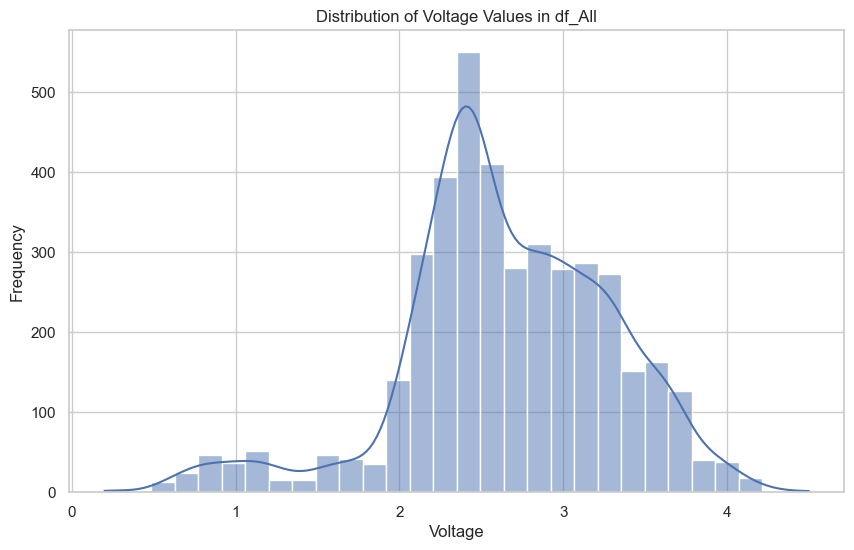

In [25]:
# Create the plot for Voltage distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_All['Voltage'], bins=30, kde=True)
plt.title('Distribution of Voltage Values in df_All')
plt.xlabel('Voltage')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Filter the DataFrame for voltage values greater than 2.5
high_voltage_df_All = df_All[df_All['Voltage'] > 2.5]

# Count the number of rows with voltage values greater than 2.5
num_high_voltage_All = high_voltage_df_All.shape[0]

percent_All = round((num_high_voltage_All/df_All.shape[0]) * 100, 2)

print(f"Number of voltage values in df_All greater than 2.5: {num_high_voltage_All}")
print(f"Percentage: {percent_All}%")

Number of voltage values in df_All greater than 2.5: 2268
Percentage: 55.45%
